In [7]:
include("iLQR.jl")


iLQR

In [8]:
using iLQR
using Plots
using RigidBodyDynamics
using MeshCatMechanisms

In [13]:
function chol_minus(A,B)
    AmB = LinAlg.Cholesky(copy(A),'U')
    for i = 1:size(B,1)
        LinAlg.lowrankdowndate!(AmB,B[i,:])
    end
    U = AmB[:U]
end


function backwards_sqrt(solver::Solver,X::Array{Float64,2},U::Array{Float64,2},K::Array{Float64,3},d::Array{Float64,2})
    N = solver.N
    n = solver.model.n
    m = solver.model.m
    Q = solver.obj.Q
    R = solver.obj.R
    xf = solver.obj.xf
    Qf = solver.obj.Qf
    
    Uq = chol(Q)
    Ur = chol(R)
    Su = chol(Qf)

#     S = Qf
    s = Qf*(X[:,N] - xf)
    v1 = 0.
    v2 = 0.

    mu = 0.
    k = N-1
    while k >= 1
        lx = Q*(X[:,k] - xf)
        lu = R*(U[:,k])
        lxx = Q
        luu = R
        fx, fu = solver.F(X[:,k],U[:,k])
        Qx = lx + fx'*s
        Qu = lu + fu'*s
        
        Wxx = qrfact!([Su*fx; Uq])
        if mu > 0
            Wuu = qrfact!([Su*fu; Ur])
        else
            Wuu = qrfact!([Su*fu; Ur; eye(m)*mu])
        end
        Qxu = fx'*(Su'Su)*fu
#         Qxx = lxx + fx'*S*fx
#         Quu = luu + fu'*(S + mu*eye(n))*fu
#         Qux = fu'*(S + mu*eye(n))*fx

        # regularization
#         if any(eigvals(Quu).<0.)
#             mu = mu + 1.0;
#             k = N-1;
#             println("regularized")
#         end
        println(isposdef(Wuu'Wuu))
        
        
        K[:,:,k] = Wuu[:R]\(Wuu[:R]'\Qxu')
        d[:,k] = Wuu[:R]\(Wuu[:R]'\Qu)
#         K[:,:,k] = Quu\Qux
#         d[:,k] = Quu\Qu
        
        s = (Qx' - (Wuu[:R]'\Qu)'*(Wuu[:R]'\Qxu'))'
        Su = chol_minus(Wxx[:R],Wuu[:R]'\Qxu')
#         s = (Qx' - Qu'*K[:,:,k] + d[:,k]'*Quu*K[:,:,k] - d[:,k]'*Qux)'
#         S = Qxx + K[:,:,k]'*Quu*K[:,:,k] - K[:,:,k]'*Qux - Qux'*K[:,:,k]
        

        # terms for line search
        v1 += float(d[:,k]'*Qu)[1]
        v2 += float(d[:,k]'*Wuu[:R]'Wuu[:R]*d[:,k])

        k = k - 1;
    end
    return K, d, v1, v2
    
end


function solve_sqrt(solver::iLQR.Solver,U::Array{Float64,2},iterations::Int64=100,eps::Float64=1e-3)
    N = solver.N
    n = solver.model.n
    m = solver.model.m
    X = zeros(n,N)
    X_ = similar(X)
    U_ = similar(U)
    K = zeros(m,n,N-1)
    d = zeros(m,N-1)

    X[:,1] = solver.obj.x0

    # initial roll-out
    iLQR.rollout!(solver, X, U)
    J_prev = iLQR.cost(solver, X, U)
    println("Initial Cost: $J_prev\n")

    for i = 1:iterations
        println("*** Iteration: $i ***")
        K, d, v1, v2 = backwards_sqrt(solver,X,U,K,d)
        J = iLQR.forwardpass!(X_, U_, solver, X, U, K, d, v1, v2)

        X = copy(X_)
        U = copy(U_)

        if abs(J-J_prev) < eps
            println("-----SOLVED-----")
            println("eps criteria met at iteration: $i")
            break
        end

        J_prev = copy(J)
    end

    return X, U
end

solve_sqrt (generic function with 6 methods)

In [14]:
## Double pendulum
urdf_dp = "urdf/doublependulum.urdf"
dp = iLQR.Model(urdf_dp)
n = dp.n
m = dp.m

# initial and goal states
x0 = [0.;0.;0.;0.]
xf = [pi;0.;0.;0.]

# costs
Q = 0.0001*eye(4)
Qf = 250.0*eye(4)
R = 0.0001*eye(2)

# simulation
tf = 5.0
dt = 0.1

obj = iLQR.Objective(Q,R,Qf,tf,x0,xf)
solver = iLQR.Solver(dp,obj,dt=dt);

In [11]:
function makePSD(A,δ=1.)
    n = size(A,1)
    mu = 0
    for i = 1:100
        if ~isposdef(A)
            mu += δ
            A += mu*eye(n)
        else
            break;
        end
    end
    return A
end

makePSD (generic function with 2 methods)

In [145]:
X = zeros(n,N)
K = zeros(m,n,N-1)
d = zeros(m,N-1)
X[:,1] = solver.obj.x0
iLQR.rollout!(solver,X,U)

S = Qf
s = Qf*(X[:,N] - xf)
mu = 4000
for k = 49:-1:40
    lx = Q*(X[:,k] - xf)
    lu = R*(U[:,k])
    lxx = Q
    luu = R
    fx, fu = solver.F(X[:,k],U[:,k])
    Qx = lx + fx'*s
    Qu = lu + fu'*s
    Qxx = lxx + fx'*S*fx
    Quu = luu + fu'*(S )*fu + mu*eye(m)
    Qux = fu'*(S + mu*eye(n)*0)*fx

    K[:,:,k] = Quu\Qux
    d[:,k] = Quu\Qu
    s = (Qx' - Qu'*K[:,:,k] + d[:,k]'*Quu*K[:,:,k] - d[:,k]'*Qux)'
    S = Qxx + K[:,:,k]'*Quu*K[:,:,k] - K[:,:,k]'*Qux - Qux'*K[:,:,k]
    println("X: $(X[:,k])")
    println("fu: $fu")
    println("Quu: $Quu")
end
isposdef(Quu)

X: [-0.110137, 0.904388, 0.86213, -2.17147]
fu: [0.00536415 -0.00838484; -0.00830162 0.0167282; 0.113622 -0.182675; -0.180225 0.364418]
Quu: [4011.37 -21.6542; -21.6542 4041.63]
X: [-0.176699, 1.08335, 0.472563, -1.41566]
fu: [0.00454117 -0.00652041; -0.00643258 0.0129902; 0.0939773 -0.13913; -0.136517 0.276987]
Quu: [4008.44 -16.6278; -16.6278 4033.16]
X: [-0.205651, 1.18936, 0.111813, -0.712626]
fu: [0.00416213 -0.00556541; -0.00547366 0.0110737; 0.0843714 -0.115707; -0.112979 0.229916]
Quu: [4005.12 -10.8918; -10.8918 4023.56]
X: [-0.200199, 1.22727, -0.215161, -0.0509441]
fu: [0.00401096 -0.00513552; -0.00504241 0.0102107; 0.0802653 -0.104384; -0.101602 0.207136]
Quu: [4002.42 -5.97078; -5.97078 4015.19]
X: [-0.163777, 1.20039, -0.507747, 0.585377]
fu: [0.00398648 -0.00505603; -0.0049677 0.0100548; 0.0790753 -0.100675; -0.0979985 0.19975]
Quu: [4000.85 -2.50458; -2.50458 4008.71]
X: [-0.0997156, 1.11064, -0.768597, 1.20799]
fu: [0.00406693 -0.00528569; -0.00521091 0.0105264; 0.0799

4×4 Array{Float64,2}:
 250.0    0.0    0.0    0.0
   0.0  250.0    0.0    0.0
   0.0    0.0  250.0    0.0
   0.0    0.0    0.0  250.0

In [16]:
U = 5.0*ones(solver.model.m,solver.N)
X_dp, U_dp = @time iLQR.solve(iLQR.Solver(solver),U);

Initial Cost: 2552.696395302164

*** Iteration: 1 ***
New cost: 1490.204042651116
- Expected improvement: 1435.8070195932864
- Actual improvement: 1062.4923526510481
- (z = 0.7399966277863823)

*** Iteration: 2 ***
New cost: 875.5826591229408
- Expected improvement: 838.1260598822855
- Actual improvement: 614.6213835281752
- (z = 0.7333280910206975)

*** Iteration: 3 ***
New cost: 528.4421633400357
- Expected improvement: 492.42015919854043
- Actual improvement: 347.1404957829051
- (z = 0.7049680832480711)

*** Iteration: 4 ***
New cost: 325.2416110807041
- Expected improvement: 297.17092872271553
- Actual improvement: 203.20055225933157
- (z = 0.6837834142549458)

*** Iteration: 5 ***
New cost: 197.00207042472033
- Expected improvement: 182.87189097477787
- Actual improvement: 128.23954065598377
- (z = 0.7012534292307989)

*** Iteration: 6 ***
New cost: 65.84568423664255
- Expected improvement: 246.0754446517043
- Actual improvement: 131.15638618807776
- (z = 0.5329925802784459)

*** 

In [18]:
U = 5.0*ones(solver.model.m,solver.N)
X_sr, U_sr = @time solve_sqrt(solver,U);

Initial Cost: 2552.696395302164

*** Iteration: 1 ***


LoadError: [91mMethodError: no method matching backwards_sqrt(::iLQR.Solver, ::Array{Float64,2}, ::Array{Float64,2}, ::Array{Float64,3}, ::Array{Float64,2})[0m
Closest candidates are:
  backwards_sqrt([91m::iLQR.Solver[39m, ::Array{Float64,2}, ::Array{Float64,2}, ::Array{Float64,3}, ::Array{Float64,2}) at In[13]:11[39m

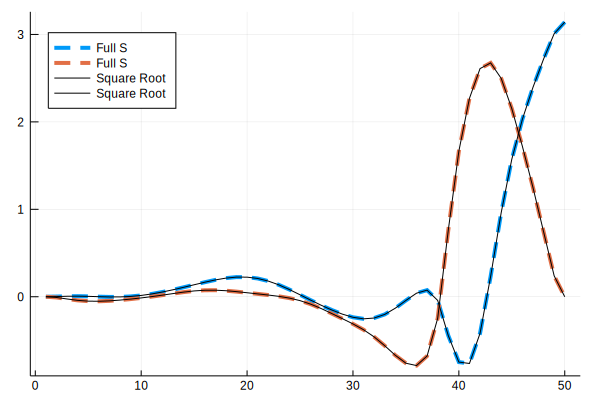

In [35]:
plot(X_dp[1:2,:]',label="Full S",width=4,style=:dash)
plot!(X_sr[1:2,:]',label="Square Root",color="black",legend=:topleft)

In [113]:
vis = MechanismVisualizer(doublependulum,URDFVisuals(urdf));
IJuliaCell(vis)
for i = 1:size(X_dp,2)
    set_configuration!(state, X_dp[1:2,i])
    set_configuration!(vis, configuration(state))
    sleep(dt)
end

LoadError: [91mUndefVarError: MechanismVisualizer not defined[39m

makePSD_current (generic function with 1 method)

LoadError: [91mUndefVarError: A not defined[39m